In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import Models.OWID as owid
import Models.SIRD as sird
import Models.GradientDescent as gd

import scipy.optimize as opt

#parameters are [A(0), I(0), gamma0, gamma1, nu, beta0, beta1, beta2, u(t) vars]
#consts are [dayNum, I[0], maxI]

#A' = (b0 / (1 + (((dayNum)*b3 + b1) * I)**(b2 ) )*A - gamma0*A
#I' = gamma1*A - nu*I


def startFunc(consts):
    
    #return ukVars
    params = np.zeros(9)
        
    params[0] = .001 + consts[1] #A(0), between 0 and 10 percent of the population
    params[1] = consts[1] #10e-10 + random.random()*.01 #I(0), between 0 and .1 percent of the population, avoid 0
    
    params[2] = .1 + random.random()*.4 #gamma0, asympt->recovs + infected - floor asympt infect rate
    params[3] = .001 + random.random()*.1 #gamma1, asympt->infected
    
    params[4] = .001 + random.random()*.1 #nu, infected -> recov or dead

    params[5] = .3 + random.random()*1.5 #beta0, ceiling infectRate - floor infect rate
    params[6] = 13 + 125*random.random() #beta2, scaler on feedback
    params[7] = .5 + random.random()*2 #beta3, exponential [.5, 5.5]
    
    params[8] = 100 * (random.random()-.5) #-50 to 50, time based u(t)
    
    #beta1 = (b0/gamma0 - 1)**(1/u(t)*b2) / maxI
    #params[6] = ((params[5]/params[2])-1)**(1/(params[7])) / consts[2]
    
    
    return params
    
def simFunc(params, consts, giveA=False): #option to return A and I

    dayNum = consts[0]
    
    A = np.zeros((dayNum))
    I = np.zeros((dayNum))
    
    A[0] = params[0]
    I[0] = params[1]
    
    gamma0 = params[2]
    gamma1 = params[3]
    nu = params[4]
    
    beta = params[5:9]

    #print(params)
    
    #iterate the arrays using the definition K' and I'
    for t in range(len(I)-1): #define I and K on range [1, length)
        diffA = (beta[0]/ (1 + ((beta[1] + (t/dayNum)*beta[3])*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]
        diffI = gamma1*A[t] - nu*I[t]
        
        A[t+1] = diffA + A[t]
        I[t+1] = diffI + I[t]

    if(giveA):
        return A,I
        
    return I #I is the data generated

def graphParams(params, consts, graphA=False):
    A, I = simFunc(params, consts, giveA=True)
    
    fig, ax = plt.subplots(figsize=(18,8))
    if(graphA):
        ax.plot(A, color="orange", linestyle="dashed", alpha=.7)
    ax.plot(I, color="red")
    return fig, ax




#x is the starting params, args = (consts, y)
def errFunc(x, consts, normalWeight, slopeWeight, wDecay, skip, y):
    
    def simFunction(params, consts, giveA=False): #option to return A and I

        dayNum = consts[0]

        A = np.zeros((dayNum))
        I = np.zeros((dayNum))

        A[0] = params[0]
        I[0] = params[1]

        gamma0 = params[2]
        gamma1 = params[3]
        nu = params[4]

        beta = params[5:9]

        #print(params)

        #iterate the arrays using the definition K' and I'
        for t in range(len(I)-1): #define I and K on range [1, length)
            diffA = (beta[0]/ (1 + ((beta[1] + (t/dayNum)*beta[3])*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]
            diffI = gamma1*A[t] - nu*I[t]

            A[t+1] = diffA + A[t]
            I[t+1] = diffI + I[t]

        if(giveA):
            return A,I

        return I #I is the data generated

    x = simFunction(x, consts)
    
    error = 0
    if(normalWeight!=0):
        for t in range(skip,len(y)):
            error = error + ((y[t] - x[t])**2)*wDecay**(len(y)-t+1) #squared error
        error = error / len(y) # / T, average error
    
    
    slopeError = 0
    if(slopeWeight!=0):
        dy = np.diff(y)
        dx = np.diff(x)
        for t in range(skip,len(dy)):
            slopeError = slopeError +  ((dy[t] - dx[t])**2)*wDecay**(len(dy)-t+1) #squared error
        slopeError = slopeError / len(dy) # / T, average error

    return error*normalWeight + slopeError*slopeWeight



def getParams(I, consts, normalWeight=1, slopeWeight=0, wDecay=1, skip=0, randomIterCount=100, method="SLSQP"):
    bestParams = startFunc(consts)
    bestError = 10e10 #arbitrary large value
    
    for i in range(randomIterCount):
        
        newParams = startFunc(consts)
        newParams = opt.minimize(errFunc, newParams, (consts, normalWeight, slopeWeight, wDecay, skip, I), method=method)['x']
        newError = errFunc(newParams, consts, normalWeight, slopeWeight, wDecay, skip, I)
    
        if(newError < bestError):
            bestError = newError
            bestParams = newParams
            print(i, "New best error: ", bestError)
            
    return bestParams

def getStablePoint(params, consts):
    #I stable point = (b0/gamm0 - 1)^(1/b2) / b1
    #A stable point = nu/gamma1 * (b0/gamm0 - 1)^(1/b2) / b1
    
    gamma0 = params[2]
    gamma1 = params[3]
    nu = params[4]
    beta = params[5:]
    
    return (beta[0]/gamma0 - 1)**(1/beta[2]) / beta[1]

2020-03-13 2020-03-05


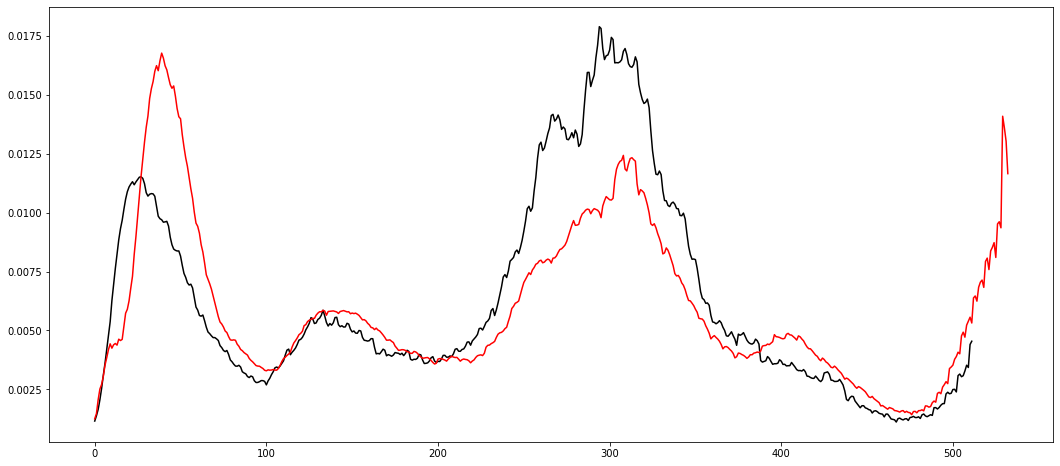

In [8]:
dates, I, R, D, V = owid.LoadCountryNormalDeaths("United States", shiftAmount=15)
dates2, I2, R2, D2, V2 = owid.LoadCountryNormal("United States")

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(I, color="black")
ax.plot(I2, color="red")

print(dates[0], dates2[0])

consts = [len(I), I[0], max(I), 0]

## Italy

<ipython-input-1-8c98ad764f12>:109: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + ((beta[1] + (t/dayNum)*beta[3])*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  1.9243861602899424e-05
10 New best error:  1.6229496339793796e-05
[7.14138573e-03 6.16433318e-04 1.93554034e+00 2.26923853e-01
 1.65364107e-02 1.99619523e+00 2.65934106e+01 2.22359080e+00
 5.91377107e+00]


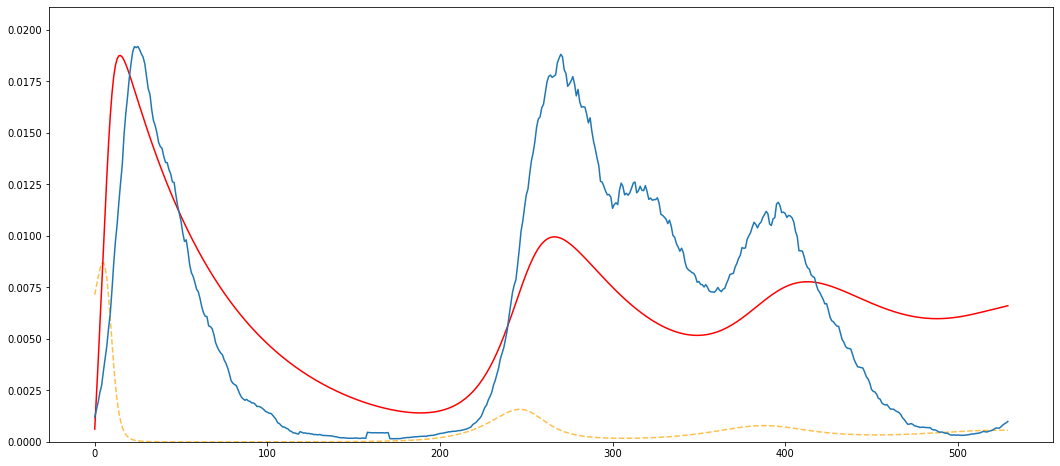

In [6]:
dates, I, R, D, V = owid.LoadCountryNormalDeaths("Italy", shiftAmount=18)

#dates = dates[100:]
#I = I[100:]
#R = R[100:]
#D = D[100:]
#V = V[100:]

consts = [len(I), I[0], max(I), 0]

italyParams = getParams(I, consts, randomIterCount=50, method = "Nelder-Mead")

#italyParamsCopy = italyParams.copy()
#italyParamsCopy[2] = italyParamsCopy[-3]-.01
#italyParamsCopy[-2] = 45
#italyParamsCopy[-1] = 10

fig,ax = graphParams(italyParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

print(italyParams)

## US

<ipython-input-31-8c98ad764f12>:109: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + ((beta[1] + (t/dayNum)*beta[3])*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  1.0144131778211845e-05
19 New best error:  8.03745919175351e-06
62 New best error:  5.763339089378447e-06
84 New best error:  5.601777941025169e-06
[ 3.37590417e-04  1.95369464e-03  8.62114351e-01  6.53575883e-02
  7.53697812e-03  1.53091031e+00  1.78930730e+02  5.77462857e+00
 -1.18956983e+02]


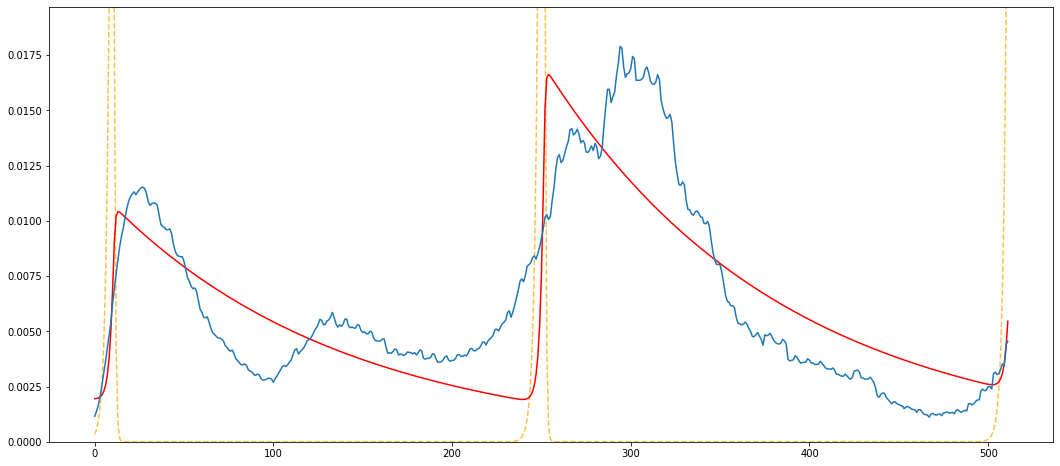

In [33]:
dates, I, R, D, V = owid.LoadCountryNormalDeaths("United States")
consts = [len(I), I[0], max(I), 0]

usParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(usParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

print(usParams)

## UK

<ipython-input-31-8c98ad764f12>:109: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + ((beta[1] + (t/dayNum)*beta[3])*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  4.9756914592289506e-05
1 New best error:  4.7008341551978806e-05
8 New best error:  4.1871831786148754e-05
10 New best error:  3.392427660728514e-05
12 New best error:  2.7817440508601562e-05
[2.83839911e-03 2.36637256e-03 1.09382900e+00 5.14743285e-03
 1.31887786e-02 2.54406880e+00 1.42824288e+02 3.12699692e+00
 2.49265112e+01]


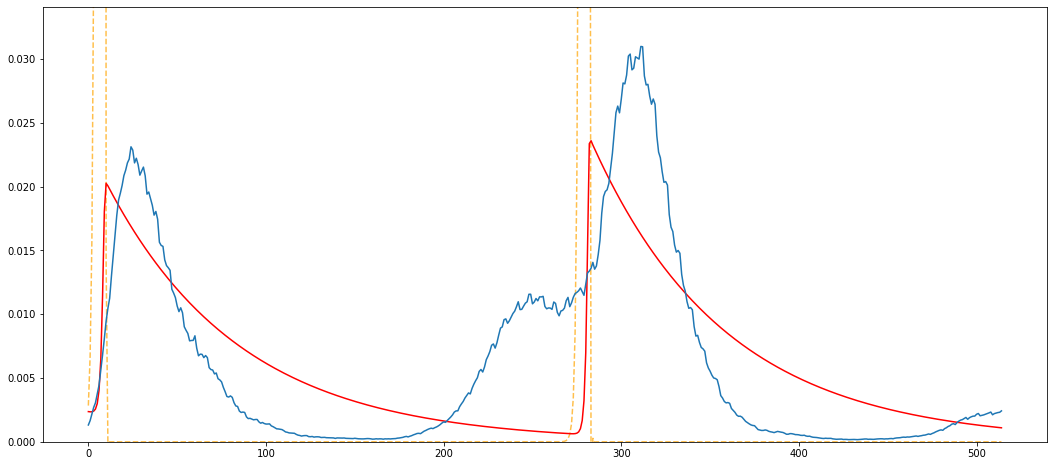

In [34]:
dates, I, R, D, V = owid.LoadCountryNormalDeaths("United Kingdom")
consts = [len(I), I[0], max(I), 0]

ukParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(ukParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

print(ukParams)

## Canada

<ipython-input-31-8c98ad764f12>:109: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + ((beta[1] + (t/dayNum)*beta[3])*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  2.513975576366343e-05
3 New best error:  1.7598094298032714e-05
9 New best error:  1.755030669821289e-05
17 New best error:  1.6768259935939e-05
45 New best error:  1.5548442657516013e-05
86 New best error:  1.4233294007685662e-05


(0.0, 0.024943007698632183)

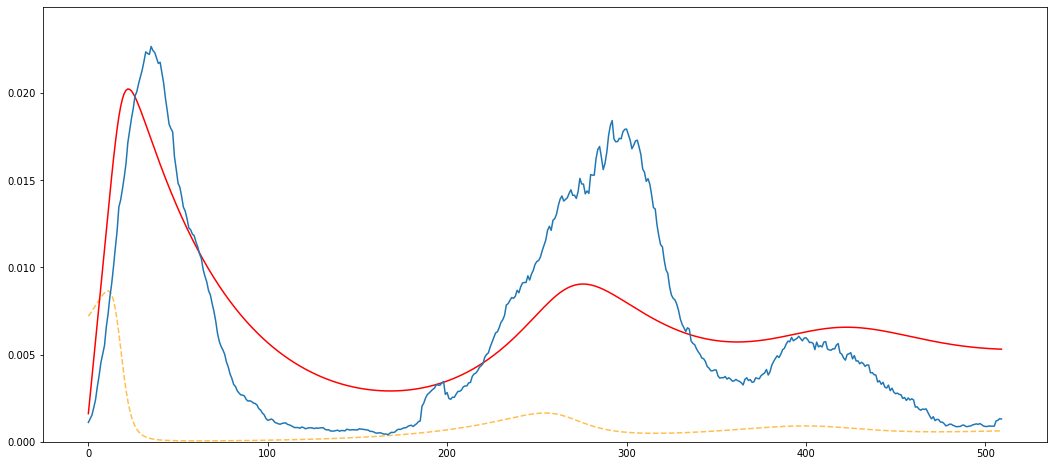

In [35]:
dates, I, R, D, V = owid.LoadCountryNormalDeaths("Canada")
consts = [len(I), I[0], max(I), 0]

canadaParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(canadaParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Mexico

<ipython-input-31-8c98ad764f12>:109: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + ((beta[1] + (t/dayNum)*beta[3])*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  7.190816172793896e-06
3 New best error:  7.071203713753486e-06
11 New best error:  6.92145314433133e-06
28 New best error:  6.888665453850856e-06
44 New best error:  6.80965534290855e-06
71 New best error:  6.769488969821349e-06


(0.0, 0.018885884069316457)

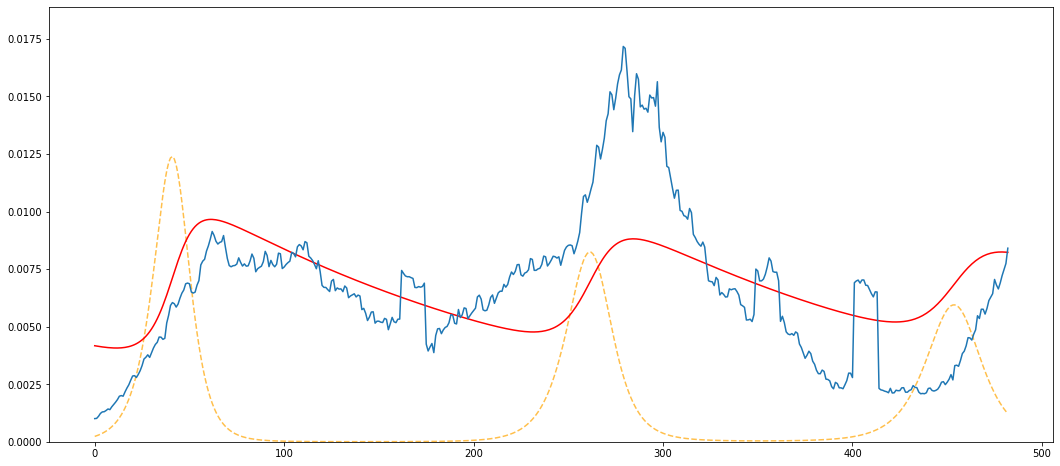

In [36]:
dates, I, R, D, V = owid.LoadCountryNormalDeaths("Mexico")
consts = [len(I), I[0], max(I), 0]

mexicoParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(mexicoParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Israel

0 New best error:  3.982591560445559e-05


<ipython-input-31-8c98ad764f12>:109: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + ((beta[1] + (t/dayNum)*beta[3])*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


1 New best error:  2.8802881061661765e-05
4 New best error:  2.6979817821968695e-05
8 New best error:  2.6494202217019582e-05
21 New best error:  2.619511525616253e-05
30 New best error:  2.586883452003784e-05
51 New best error:  2.5502830613259875e-05


(0.0, 0.03080811808118081)

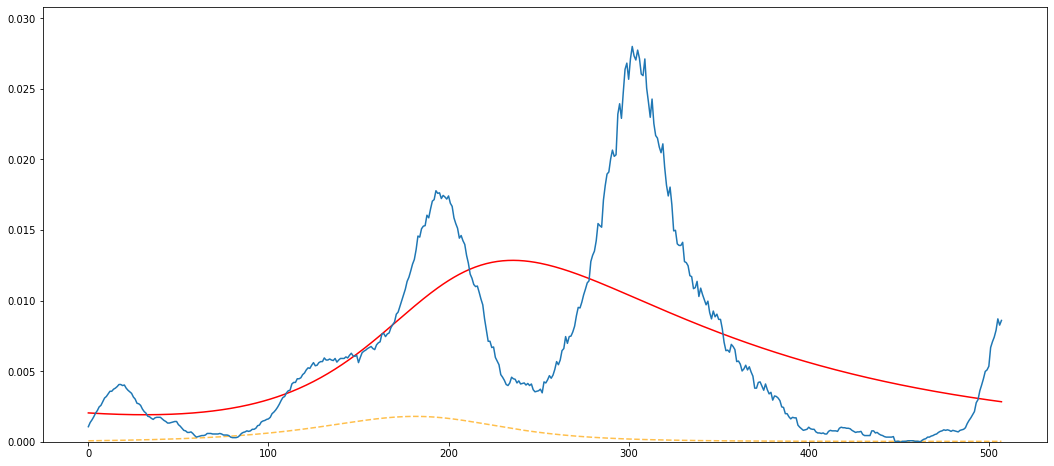

In [37]:
dates, I, R, D, V = owid.LoadCountryNormalDeaths("Israel")
consts = [len(I), I[0], max(I), 0]

israelParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(israelParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Russia

<ipython-input-31-8c98ad764f12>:109: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + ((beta[1] + (t/dayNum)*beta[3])*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


2 New best error:  1.0508168090245138e-05
3 New best error:  9.774106651278533e-07
22 New best error:  9.116298900752842e-07
36 New best error:  5.130812569234549e-07


(0.0, 0.016200793001155237)

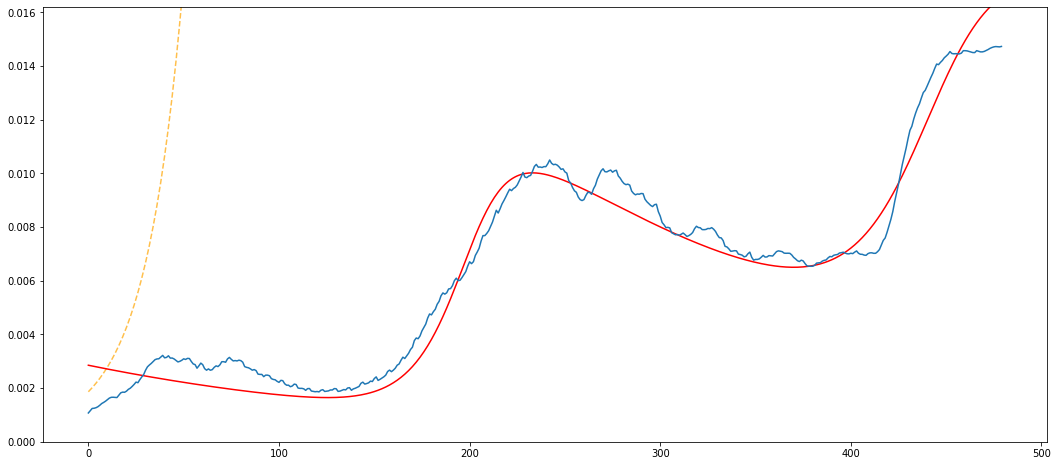

In [38]:
dates, I, R, D, V = owid.LoadCountryNormalDeaths("Russia")
consts = [len(I), I[0], max(I), 0]

russiaParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(russiaParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## South Africa

<ipython-input-31-8c98ad764f12>:109: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + ((beta[1] + (t/dayNum)*beta[3])*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  2.6738343753824014e-05
1 New best error:  2.552736583636689e-05
2 New best error:  1.4897211030520771e-05


(0.0, 0.025716079292374863)

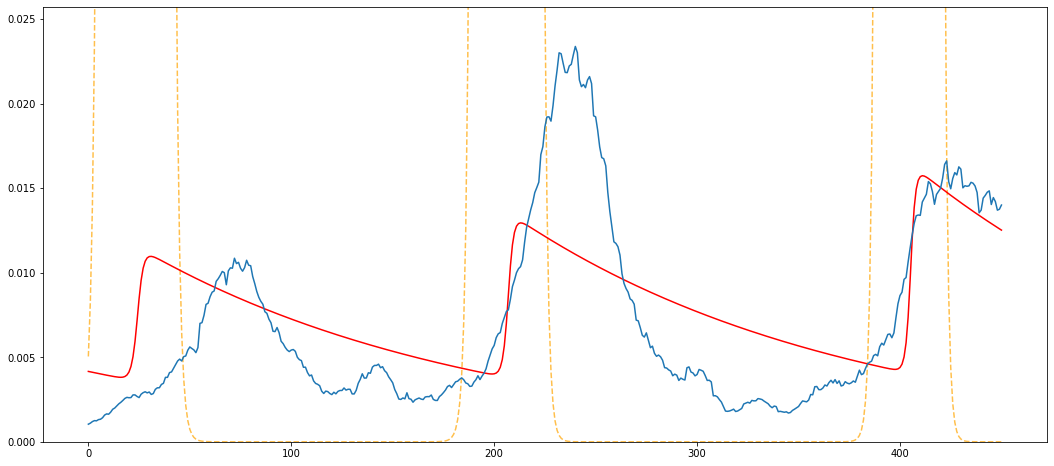

In [39]:
dates, I, R, D, V = owid.LoadCountryNormalDeaths("South Africa")
consts = [len(I), I[0], max(I), 0]

southAfricaParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(southAfricaParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Australia

0 New best error:  0.00015586232153347627


<ipython-input-31-8c98ad764f12>:109: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + ((beta[1] + (t/dayNum)*beta[3])*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


1 New best error:  7.67029398427297e-05
7 New best error:  7.274629440594149e-05


(0.0, 0.07064220183486239)

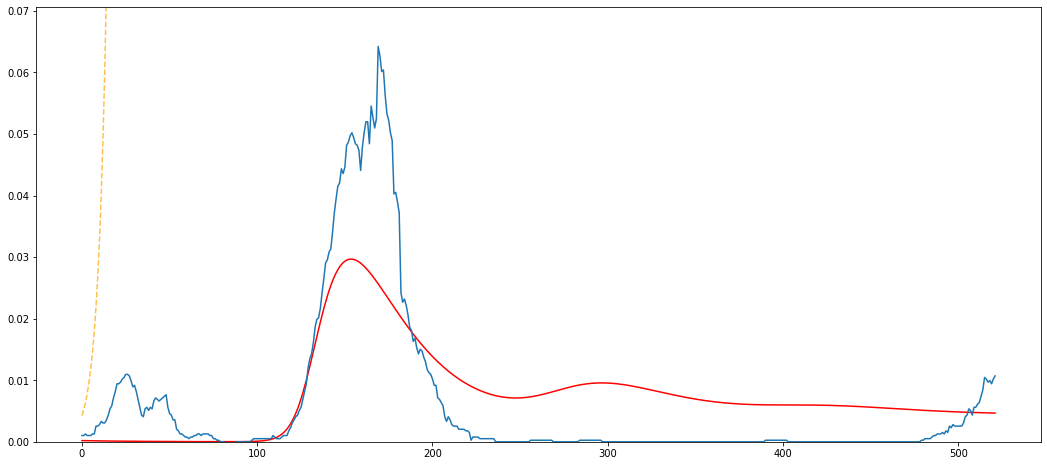

In [40]:
dates, I, R, D, V = owid.LoadCountryNormalDeaths("Australia")
consts = [len(I), I[0], max(I), 0]

auParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(auParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Turkey

<ipython-input-31-8c98ad764f12>:109: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + ((beta[1] + (t/dayNum)*beta[3])*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  2.0250119189571506e-05
1 New best error:  1.4496327833352333e-05
2 New best error:  1.0879800516218338e-05
23 New best error:  1.0685598972599423e-05
32 New best error:  1.0228228967732221e-05
56 New best error:  9.436496785674154e-06


(0.0, 0.029493621955933517)

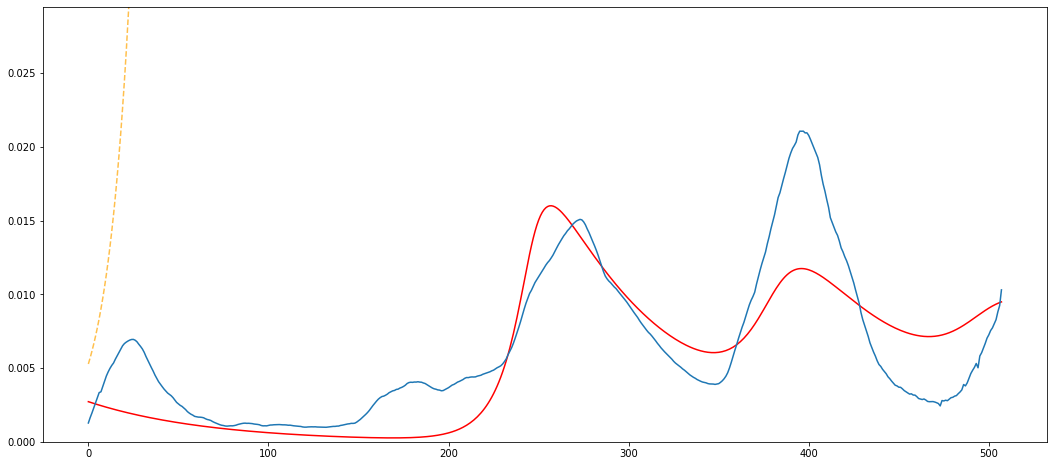

In [41]:
dates, I, R, D, V = owid.LoadCountryNormalDeaths("Turkey")

#dates = dates[10:]
#I = I[10:]
#R = R[10:]
#D = D[10:]
#V = V[10:]

consts = [len(I), I[0], max(I), 0]

#turkeyParams = getParams(I, consts, randomIterCount=500, wDecay=(.75**(1/len(I))), method = "Nelder-Mead")
turkeyParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(turkeyParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.4])

In [43]:
import csv


outputFile = open('..\\Data\\AIRD fits\\fitsDeathModel.csv', 'w')
writer = csv.writer(outputFile)


row = italyParams.tolist()
row.insert(0, "Italy")
writer.writerow(row)

row = usParams.tolist()
row.insert(0, "United States")
writer.writerow(row)

row = ukParams.tolist()
row.insert(0, "United Kingdom")
writer.writerow(row)

row = canadaParams.tolist()
row.insert(0, "Canada")
writer.writerow(row)

row = mexicoParams.tolist()
row.insert(0, "Mexico")
writer.writerow(row)

row = israelParams.tolist()
row.insert(0, "Israel")
writer.writerow(row)

row = russiaParams.tolist()
row.insert(0, "Russia")
writer.writerow(row)

row = southAfricaParams.tolist()
row.insert(0, "South Africa")
writer.writerow(row)

row = auParams.tolist()
row.insert(0, "Australia")
writer.writerow(row)

row = turkeyParams.tolist()
row.insert(0, "turkey")
writer.writerow(row)

outputFile.close()

normal-death error:  0.8241944929411675
mod-death error:  0.07253802128040525
mod/normal error: 0.08801080558249148


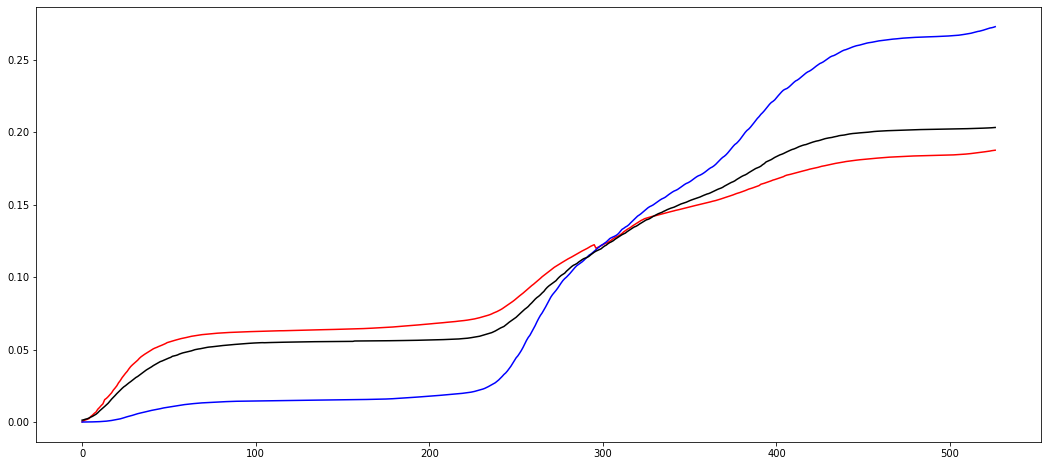

In [3]:
countryName = "Italy"

dates, I, R, D, V = owid.LoadCountryNormal(countryName)

dates2, [actualI, pop] = owid.LoadCountry(countryName, [4, 46])

startDate = np.where(dates2 == dates[0])[0][0]
endDate = np.where(dates2 == dates[-1])[0][0]

dates2 = dates2[startDate:endDate+1]
actualI = actualI[startDate:endDate+1]
pop = pop[0]

actualI = actualI/pop #transform so max pop is 1

shiftAmount = 15
deadShift = D[shiftAmount:]
modIShift = I[0:-shiftAmount] + R[0:-shiftAmount]
actualIShift = actualI[0:-shiftAmount]

fig,ax = plt.subplots(figsize=(18,8))

deathScale = (sum(modIShift)/len(modIShift)) / (sum(deadShift)/len(deadShift))
infectScale = (sum(modIShift)/len(modIShift)) / (sum(actualIShift)/len(actualIShift))

ax.plot(modIShift, color="red")
ax.plot(infectScale*actualIShift, color="blue")
ax.plot(deathScale*deadShift, color="black")

normalError = sum(((infectScale*actualIShift)-(deathScale*deadShift))**2)
modError = sum(((modIShift)-(deathScale*deadShift))**2)
print("normal-death error: ", normalError)
print("mod-death error: ", modError)
print("mod/normal error:", modError/normalError)

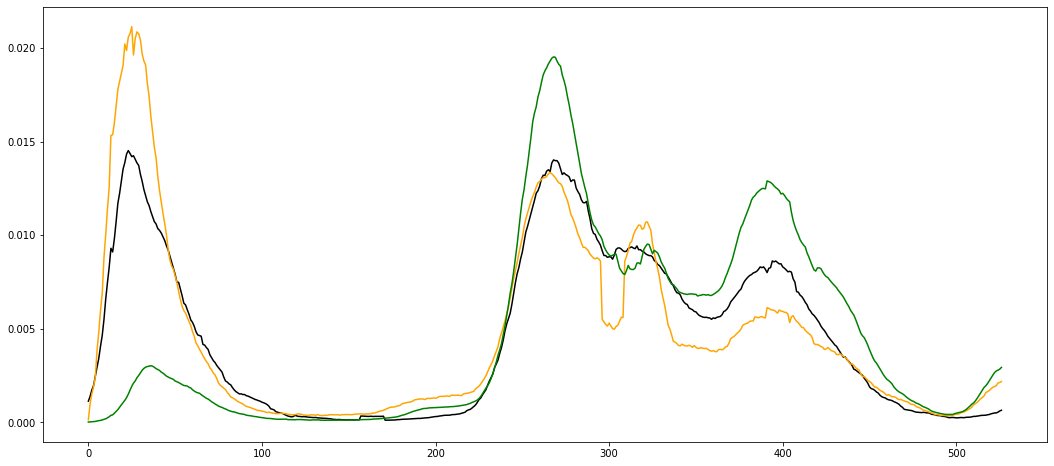

In [4]:
fig, ax = plt.subplots(figsize=(18,8))

recov = np.zeros(len(deadShift)) #R+D
shift = 14
for i in range(len(deadShift) - shift):
        recov[i + shift] = deadShift[i]

reportedI = actualIShift
recov2 = np.zeros(len(deadShift)) #R+D
for i in range(len(reportedI) - shift):
        recov2[i + shift] = reportedI[i]

reportedI = reportedI - recov2
currInfect = deadShift - recov
modIShift = I[0:-shiftAmount]

currInfect = currInfect * (sum(modIShift)/len(modIShift)) / (sum(currInfect)/len(currInfect))
reportedI = reportedI * (sum(modIShift)/len(modIShift)) / (sum(reportedI)/len(reportedI))

ax.plot(currInfect, color="black") #approx from dead
ax.plot(modIShift, color="orange") #approx from tests
ax.plot(reportedI, color="green") #reported